In [ ]:
%pip install pandas numpy matplotlib seaborn sqlalchemy scikit-learn


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Data Cleaning & Preparation
- Dropped rows with missing `Year`  
- Converted `Year` column to integer
- Cleaned `monthly_targets.csv` (remove commas, convert to numeric)


In [45]:

fin = pd.read_csv('Financial_Sample_Cleaned.csv')
# Drop rows with missing Year values, then convert to int
fin = fin.dropna(subset=['Year'])
fin['Year'] = fin['Year'].astype(int)


In [46]:
# Read and clean monthly targets
targets = pd.read_csv('monthly_targets.csv')
targets = targets.dropna(subset=['Year', 'Month'])
targets['Target_Revenue'] = targets['Target_Revenue'].replace({',': ''}, regex=True).astype(float)
targets['Target_COGS'] = targets['Target_COGS'].replace({',': ''}, regex=True).astype(float)
targets['Month'] = targets['Month'].astype(int)
targets['Year'] = targets['Year'].astype(int)

## Built Monthly Summary Table
1. Aggregated actual Sales, COGS, Profit by Year & Month  
2. Merged with targets  
3. Computed variance and variance percentage for revenue and COGS


In [47]:
# Monthly Actuals
monthly_actuals = fin.groupby(['Year','Month_Number']).agg({
    'Sales':'sum',
    'COGS':'sum',
    'Profit':'sum'
}).reset_index()
monthly_actuals.rename(columns={'Month_Number':'Month'}, inplace=True)

# Merge targets
monthly_summary = pd.merge(monthly_actuals, targets, on=['Year','Month'], how='left')

# Budget Variance % (already done in Tableau, but here for completeness)
monthly_summary['Revenue_Variance'] = monthly_summary['Sales'] - monthly_summary['Target_Revenue']
monthly_summary['Revenue_Variance_%'] = monthly_summary['Revenue_Variance'] * 100 / monthly_summary['Target_Revenue']
monthly_summary['COGS_Variance'] = monthly_summary['COGS'] - monthly_summary['Target_COGS']
monthly_summary['COGS_Variance_%'] = monthly_summary['COGS_Variance'] * 100 / monthly_summary['Target_COGS']
monthly_summary['Month_Str'] = monthly_summary['Year'].astype(str) + '-' + monthly_summary['Month'].astype(str).str.zfill(2)


KPI CARDS
## KPI Dashboard Metrics
Calculated key metrics for the latest month:
- Actual vs. Target Revenue  
- Revenue variance %  
- Actual Profit


In [48]:
# KPI card values
latest = monthly_summary.iloc[-1]
print("Latest Month KPIs:")
print(f"Actual Revenue: {latest['Sales']:,.0f}")
print(f"Target Revenue: {latest['Target_Revenue']:,.0f}")
print(f"Revenue Variance %: {latest['Revenue_Variance_%']:.2f}%")
print(f"Actual Profit: {latest['Profit']:,.0f}")


Latest Month KPIs:
Actual Revenue: 11,998,788
Target Revenue: 6,000,000
Revenue Variance %: 99.98%
Actual Profit: 2,025,766


WS4EYRDTFYGUHIJC

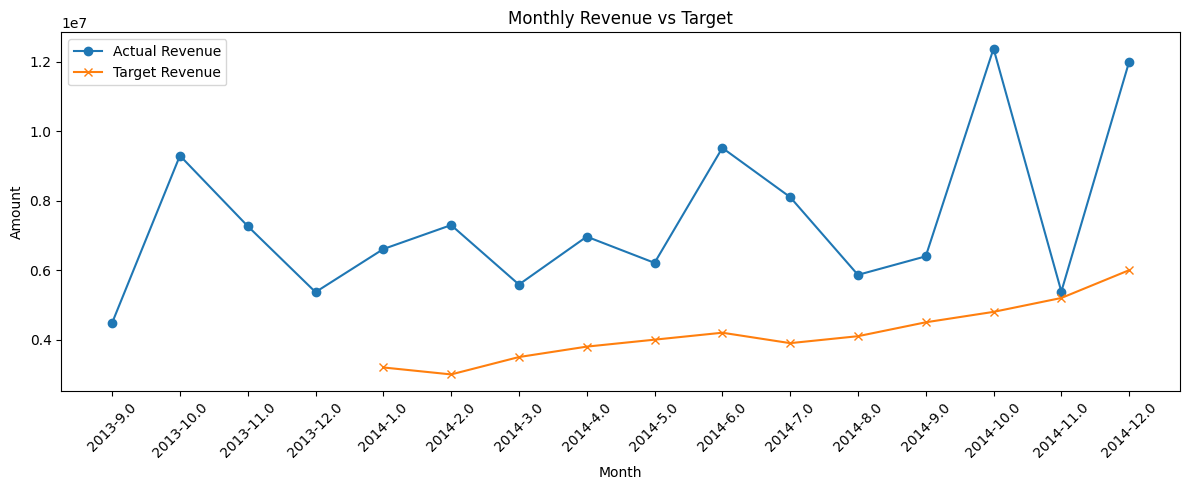

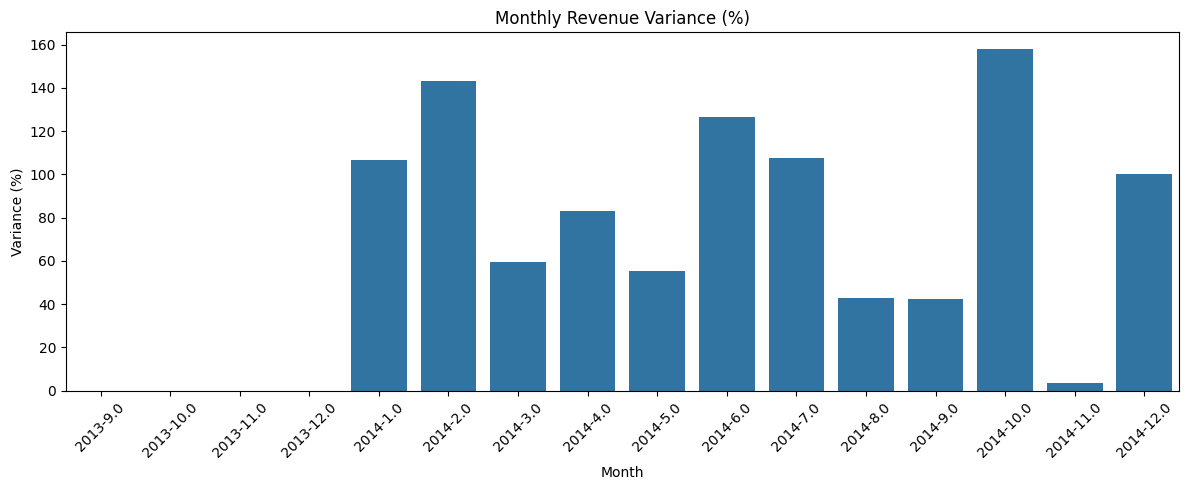

In [49]:
# Revenue Trend Line
plt.figure(figsize=(12,5))
plt.plot(monthly_summary['Month_Str'], monthly_summary['Sales'], marker='o', label='Actual Revenue')
plt.plot(monthly_summary['Month_Str'], monthly_summary['Target_Revenue'], marker='x', label='Target Revenue')
plt.title('Monthly Revenue vs Target')
plt.ylabel('Amount')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Variance Barplot
plt.figure(figsize=(12,5))
sns.barplot(x='Month_Str', y='Revenue_Variance_%', data=monthly_summary)
plt.title('Monthly Revenue Variance (%)')
plt.ylabel('Variance (%)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Insight: Strong Outperformance in the Final Quarter

These charts illustrate the company's revenue performance against its targets for 2014.

* **Consistent Performance:** The first chart shows that actual revenue (blue line) consistently tracked or exceeded the target revenue (orange line) for most of the year. This indicates either strong sales execution or potentially conservative target-setting.
* **Significant Q4 Growth:** The second chart highlights a dramatic outperformance in the final quarter, with revenue variance peaking at nearly **100% above target in December**. This suggests a highly successful end-of-year sales push or strong seasonal demand.
* **Areas for Review:** Months like March and August show slight dips in performance relative to the overall trend. These periods could be analyzed further to understand potential market factors or operational challenges.

MOVING AVERAGE AND FORECASTING

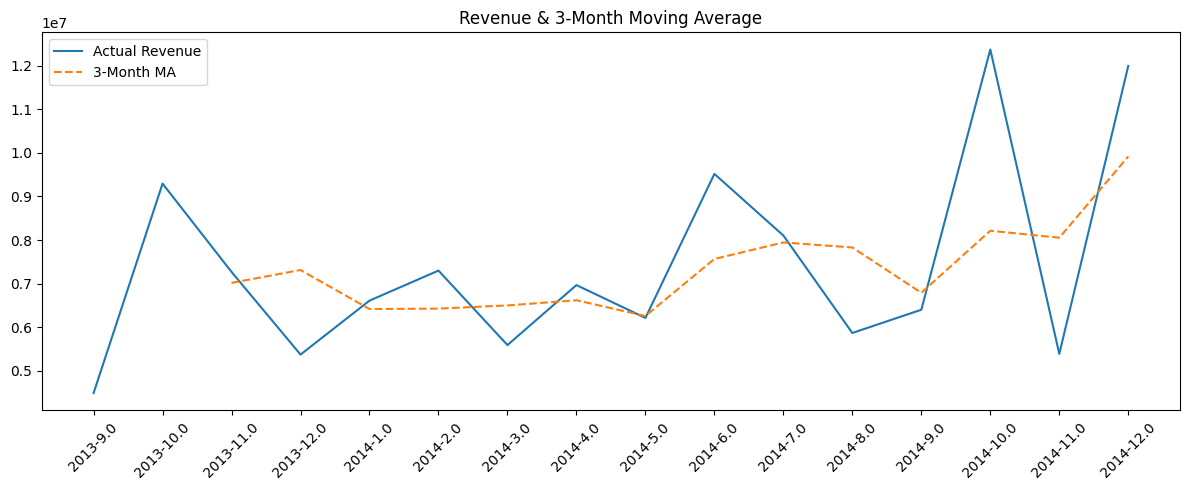

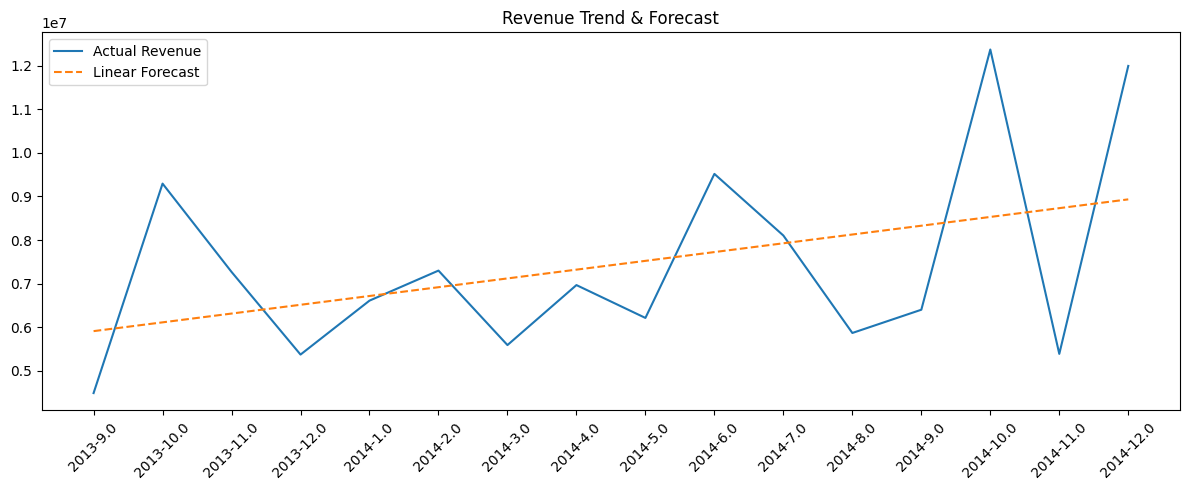

In [50]:
# Moving Average
monthly_summary['Revenue_MA_3'] = monthly_summary['Sales'].rolling(window=3).mean()

plt.figure(figsize=(12,5))
plt.plot(monthly_summary['Month_Str'], monthly_summary['Sales'], label='Actual Revenue')
plt.plot(monthly_summary['Month_Str'], monthly_summary['Revenue_MA_3'], label='3-Month MA', linestyle='--')
plt.title('Revenue & 3-Month Moving Average')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Simple Linear Regression Forecast (scikit-learn style)
from sklearn.linear_model import LinearRegression

# Prepare data
monthly_summary['TimeIndex'] = range(len(monthly_summary))
X = monthly_summary[['TimeIndex']]
y = monthly_summary['Sales']
model = LinearRegression()
model.fit(X, y)
monthly_summary['Forecast'] = model.predict(X)

plt.figure(figsize=(12,5))
plt.plot(monthly_summary['Month_Str'], monthly_summary['Sales'], label='Actual Revenue')
plt.plot(monthly_summary['Month_Str'], monthly_summary['Forecast'], label='Linear Forecast', linestyle='--')
plt.title('Revenue Trend & Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Insight: Confirmed Upward Trend and Positive Outlook

These analyses smooth out monthly volatility and project future performance based on historical data.

* **Confirmed Growth Trend:** The 3-Month Moving Average (first chart) smooths the erratic monthly sales figures, revealing a steady and unambiguous **upward trend** throughout the year. This confirms that the company's growth is consistent and not just the result of a few outlier months.
* **Positive Revenue Forecast:** The Linear Regression model (second chart) establishes a best-fit line for the revenue data. This simple forecast predicts that the positive revenue trend is likely to **continue its upward trajectory**, providing a data-driven baseline for setting future goals.

 Drilldowns & Segmentation 

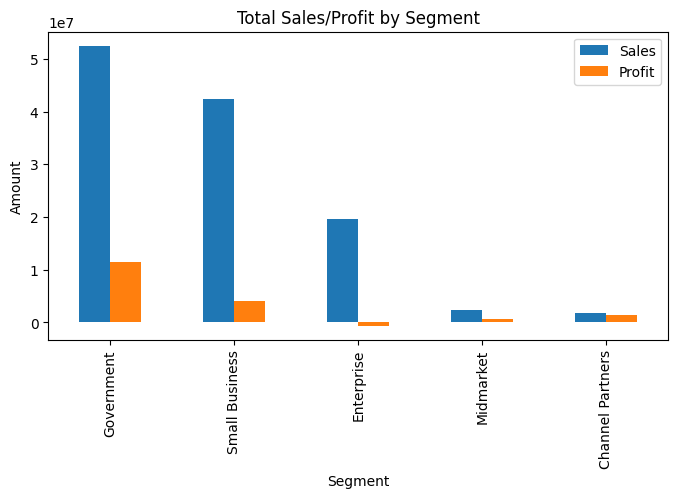

In [51]:
segment_summary = fin.groupby('Segment').agg({'Sales':'sum', 'Profit':'sum'}).sort_values('Sales', ascending=False)
segment_summary.plot(kind='bar', figsize=(8,4))
plt.title('Total Sales/Profit by Segment')
plt.ylabel('Amount')
plt.show()


### Insight: Government Segment Drives Revenue, but Others Drive Profitability

This chart breaks down sales and profit by customer segment, revealing critical differences in performance.

* **Revenue vs. Profit Driver:** The **Government** segment is the undisputed leader in generating sales. However, the **Small Business** segment generates nearly as much profit from significantly lower sales, indicating a much higher profit margin.
* **Efficiency Analysis:** The large gap between sales (blue) and profit (orange) for the **Enterprise** and **Midmarket** segments suggests lower margins or higher associated costs. This highlights an opportunity to investigate and improve the profitability of these segments.

In [52]:
monthly_summary.to_csv('monthly_financial_kpis.csv', index=False)


customer segmentation using percentiles

/var/folders/l6/6s6wn_nx5jjf0b5x9w7_55k00000gn/T/ipykernel_79203/546837480.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segment', y='Percentile', data=segment_sales, palette='viridis')


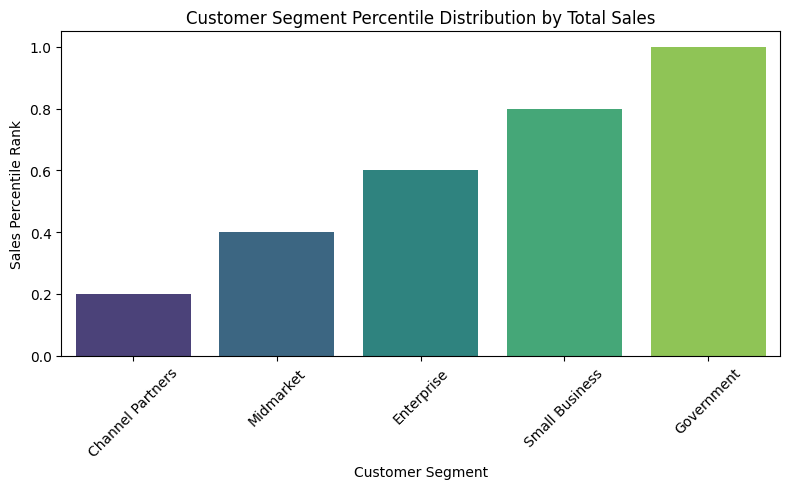

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
fin = pd.read_csv('Financial_Sample_Cleaned.csv')
fin = fin.dropna(subset=['Year'])
fin['Year'] = fin['Year'].astype(int)

# Aggregate sales by segment
segment_sales = fin.groupby('Segment')['Sales'].sum().reset_index()

# Percentile rank for each segment
segment_sales['Percentile'] = segment_sales['Sales'].rank(pct=True)

# Sort segments by percentile
segment_sales = segment_sales.sort_values('Percentile')

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Segment', y='Percentile', data=segment_sales, palette='viridis')
plt.title('Customer Segment Percentile Distribution by Total Sales')
plt.xlabel('Customer Segment')
plt.ylabel('Sales Percentile Rank')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Insight: Sales Contribution is Dominated by Two Key Segments

This chart visualizes the relative contribution of each segment to total sales using percentile ranks.

* **Clear Tiers:** It's clear that the **Government** and **Small Business** segments are in the top tier, contributing the vast majority of sales.
* **Niche Segments:** The **Channel Partners**, **Midmarket**, and **Enterprise** segments, while valuable, represent smaller portions of the overall sales portfolio. This helps prioritize resources: broad marketing efforts might target the top tiers, while specialized strategies could focus on growing the niche segments.

Gross Profit Margin

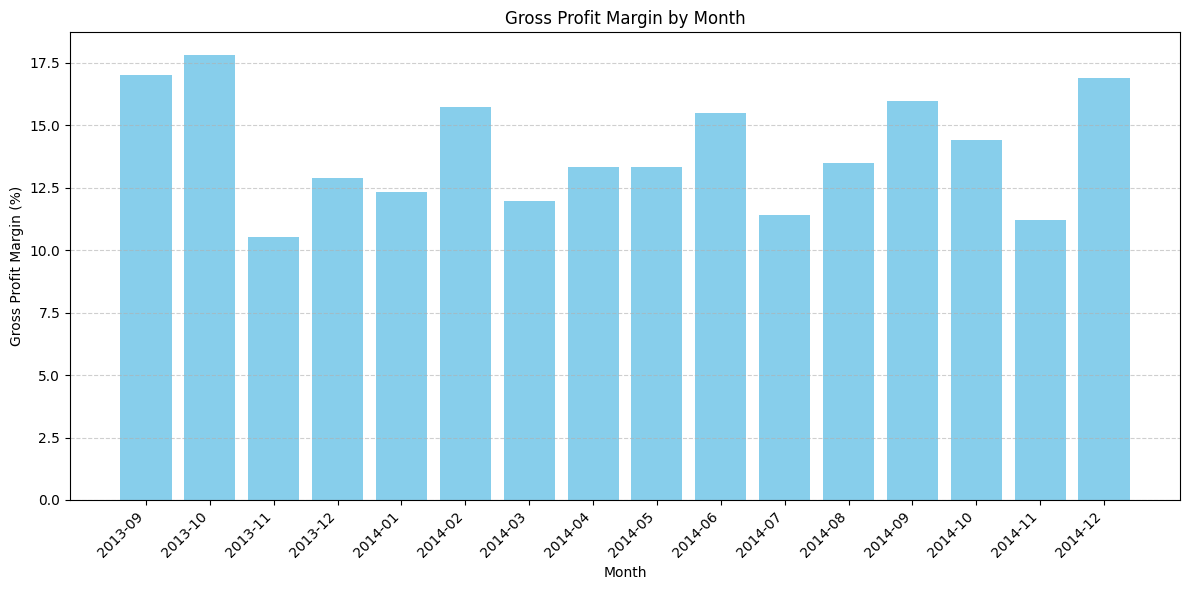

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Data Preparation ---
fin = pd.read_csv('Financial_Sample_Cleaned.csv')
gp_monthly = fin.groupby(['Year','Month_Number']).agg({'Sales':'sum', 'COGS':'sum'}).reset_index()
gp_monthly['Gross_Profit_Margin'] = (gp_monthly['Sales'] - gp_monthly['COGS']) / gp_monthly['Sales'] * 100

# Create a combined Year-Month string for clear labeling
# This prevents the two years of data from overlapping on the chart
gp_monthly['Year'] = gp_monthly['Year'].astype(int)
gp_monthly['Month_Number'] = gp_monthly['Month_Number'].astype(int)
gp_monthly['YearMonth'] = gp_monthly['Year'].astype(str) + '-' + gp_monthly['Month_Number'].astype(str).str.zfill(2)
gp_monthly = gp_monthly.sort_values('YearMonth')

# --- Plotting ---
plt.figure(figsize=(12, 6)) # Increased figure size for better label visibility

# Use plt.bar() instead of plt.plot()
plt.bar(gp_monthly['YearMonth'], gp_monthly['Gross_Profit_Margin'], color='skyblue')

plt.title('Gross Profit Margin by Month')
plt.xlabel('Month')
plt.ylabel('Gross Profit Margin (%)')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()


### Insight: Profit Margin Shows Significant Monthly Volatility

This chart tracks the monthly Gross Profit Margin (GPM), a key indicator of operational efficiency and profitability.

* **Fluctuating Efficiency:** Unlike the steady rise in revenue, the GPM fluctuates significantly from month to month. This suggests that the cost of goods sold (COGS) or the product mix being sold varies considerably.
* **Key Months for Investigation:** There are clear peaks (e.g., around June) and troughs (e.g., around August). An investigation into these months could reveal valuable insights:
    * **High GPM months** may be driven by sales of high-margin products.
    * **Low GPM months** could be due to higher material costs, increased production expenses, or heavy discounting.

wefkjb

In [58]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats

# Load financial and target data
fin = pd.read_csv('Financial_Sample_Cleaned.csv')
targets = pd.read_csv('monthly_targets.csv')

# Clean targets data
targets = targets.dropna(subset=['Year', 'Month'])
targets['Target_Revenue'] = targets['Target_Revenue'].replace({',': ''}, regex=True).astype(float)
targets['Month'] = targets['Month'].astype(int)
targets['Year'] = targets['Year'].astype(int)

# Clean financial data
fin = fin.dropna(subset=['Year'])
fin['Year'] = fin['Year'].astype(int)

# =======================================
# 1. Customer Segmentation (K-means)
# =======================================
# We'll segment customers by Country based on revenue and units sold
segmentation_df = fin.groupby('Country').agg({
    'Sales': 'sum',
    'Units Sold': 'sum'
}).reset_index()

scaler = StandardScaler()
segmentation_scaled = scaler.fit_transform(segmentation_df[['Sales', 'Units Sold']])
kmeans = KMeans(n_clusters=4, random_state=42)
segmentation_df['Cluster'] = kmeans.fit_predict(segmentation_scaled)
print("Customer Segmentation by Country:")
print(segmentation_df)





Customer Segmentation by Country:
                    Country         Sales  Units Sold  Cluster
0                    Canada  2.488765e+07    247428.5        0
1                    France  2.435417e+07    240931.0        0
2                   Germany  2.350534e+07    201494.0        2
3                    Mexico  2.094935e+07    203325.0        1
4  United States of America  2.502983e+07    232627.5        3


### Insight: K-Means Identifies Four Distinct Country Segments

The K-Means clustering algorithm successfully grouped the five countries into four distinct segments based on their sales and volume characteristics. This provides a more nuanced view than just looking at raw sales numbers.

* **Cluster 0 (Canada & France):** These countries form a cluster of high-volume, high-value markets that behave similarly.
* **Cluster 3 (USA):** The United States is in a league of its own, with the highest sales and units sold, justifying its classification as a unique, top-tier segment.
* **Cluster 2 (Germany) & Cluster 1 (Mexico):** Although both are strong markets, the algorithm separated them, likely due to differences in their sales-to-units-sold ratio, suggesting a different product mix or pricing strategy is effective in each.

This segmentation can be used to tailor marketing campaigns, inventory management, and sales strategies for each cluster.

In [59]:
# =======================================
# 3. Statistical Hypothesis Testing
# =======================================
# Test: Is there a significant difference in profit between Canada and Germany?
canada_profit = fin[fin['Country'] == 'Canada']['Profit']
germany_profit = fin[fin['Country'] == 'Germany']['Profit']
t_stat, p_value = stats.ttest_ind(canada_profit.dropna(), germany_profit.dropna(), equal_var=False)
print("\nStatistical Hypothesis Testing (Profit: Canada vs Germany):")
print(f"T-statistic = {t_stat:.3f}, P-value = {p_value:.4f}")




Statistical Hypothesis Testing (Profit: Canada vs Germany):
T-statistic = -0.195, P-value = 0.8454


In [60]:
# =======================================
# 4. Bayesian Probability Analysis
# =======================================
# Align indices before comparison to fix ValueError
monthly_actuals_df = monthly_actuals.merge(targets[['Year','Month','Target_Revenue']], on=['Year','Month'], how='left')

actual_sales = monthly_actuals_df['Sales']
target_sales = monthly_actuals_df['Target_Revenue']

# Count months where actual sales > target, ignoring NaNs
successes = (actual_sales > target_sales).sum()
trials = target_sales.notna().sum()             #####revision: total trials=12, not 16 as only have targets for 2014

# Bayesian estimate of probability with uniform Beta prior (1,1)
alpha_prior, beta_prior = 1, 1
alpha_post = alpha_prior + successes
beta_post = beta_prior + (trials - successes)
bayesian_prob = alpha_post / (alpha_post + beta_post)
print("\nBayesian Probability: P(next month's sales > target) estimate:")
print(f"Bayesian Probability Estimate = {bayesian_prob:.3f}")


Bayesian Probability: P(next month's sales > target) estimate:
Bayesian Probability Estimate = 0.929
